# LangGraph Design Patterns

#TODO: give me a brief two-sentence description of the notebook and then an outline of all of sections with a bried desctription of what we do in each of the sections
  

## Set up the Environment and Components

#TODO provide two sentence descripton of the section

In [1]:
! pip install langchain-core langgraph ipython-extensions typing-extensions langchain_openai

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 967.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 8.3 MB/s eta 0:00:00
  Created wheel for ipython-extensions: filename=ipython_extensions-0.2-py3-none-any.whl size=4805 sha256=5489db34c09724c2c4f2654d3d69900a1dd54fec2da21f0cd377712fa40b72ed
  Stored in directory: /root/.cache/pip/wheels/7f/88/c2/d93e5fa3ce6a194e9e752b39dae37a95834fea2ad4afb015f8
Successfully built ipython-extensions


In [2]:
# Import the required libraries
from typing import Annotated
from typing_extensions import TypedDict
import random
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import MessagesState

from IPython.display import Image, display

Setting up a connection to a proprietary remote model

In [3]:
# # Set OpenAI API Key
# import os, getpass

# def _set_env(var: str):
#     if not os.environ.get(var):
#         os.environ[var] = getpass.getpass(f"{var}: ")

# _set_env("OPENAI_API_KEY")

KeyboardInterrupt: Interrupted by user

In [4]:
# @title Loading the `config.json` file
import json
from langchain_openai import ChatOpenAI
import os

# Load the JSON file and extract values
file_name = 'config.json'
with open(file_name, 'r') as file:
    config = json.load(file)
    os.environ['OPENAI_API_KEY'] = config.get("API_KEY") # Loading the API Key
    os.environ["OPENAI_BASE_URL"] = config.get("OPENAI_API_BASE") # Loading the API Base Url

In [5]:
gpt4o_chat = ChatOpenAI(model="gpt-4o", temperature=0)
gpt4o_chat.invoke("hello world")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 9, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f5bdcc3276', 'id': 'chatcmpl-Bf5H86fnjoyHuiWiaY09Te3vwdt6Y', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--6e886e63-48b3-4f26-b5c1-d058158c80ec-0', usage_metadata={'input_tokens': 9, 'output_tokens': 9, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

Create some tools for the LLM

In [6]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

In [7]:
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

In [8]:
def determine_outcome(bet: int) -> str:
    """Roll a pair of dice and determine wether the sum of that roll is less than the bet

    Args:
        bet: the number that you believe the dice sum will be less than or equal to (number between 1 and 12)
    """
    roll = random.randint(1, 6) + random.randint(1, 6)

    return 'success' if roll <= bet else 'failure'

Bind the tools to the LLM

In [9]:
llm_with_tools = gpt4o_chat.bind_tools([multiply, determine_outcome])

In [10]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3",)])

In [11]:
tool_call.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (call_q2EGrQ2DGbVLvyo1rHfW06nW)
 Call ID: call_q2EGrQ2DGbVLvyo1rHfW06nW
  Args:
    a: 2
    b: 3


## Set up the State

#TODO provide two sentence descripton of the section

In [12]:
class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built
    pass

A brief look at reducers
Reducers allow us to specify how state updates are performed. If no reducer function is specified, then it is assumed that updates to the key should override it as we saw before.

To append messages, we can use the pre-built add_messages reducer.

In [13]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I need help understanding probability theory.", name="User")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='7fc2f29d-2084-4de6-8b3e-98fcb2b4d28e'),
 HumanMessage(content='I need help understanding probability theory.', additional_kwargs={}, response_metadata={}, name='User', id='781494c5-39db-4e42-aa6d-c7ffe8fb1103'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='c19953fd-ffd1-42d9-bc3c-1a562b0a3ee8')]

## Create a Chain

#TODO provide two sentence descripton of the section

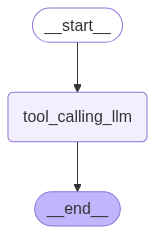

In [14]:
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! How can I assist you today?


In [16]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 5 and 7")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 5 and 7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_hIQrlQLRFkbBfVR3XRZUIugf)
 Call ID: call_hIQrlQLRFkbBfVR3XRZUIugf
  Args:
    a: 5
    b: 7


In [17]:
messages = graph.invoke({"messages": HumanMessage(content="Bet 6 against a dice roll")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Bet 6 against a dice roll
================================== Ai Message ==================================
Tool Calls:
  determine_outcome (call_5X3djpW04FjlzBncwhRTPBbn)
 Call ID: call_5X3djpW04FjlzBncwhRTPBbn
  Args:
    bet: 6


## Create a Router

#TODO provide two sentence descripton of the section. Make sure to talk about the LangGraph built in ToolNode and tools_condition for the conditional edge. Also decribe how this one is different than our previous chain

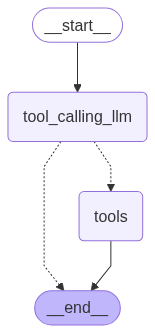

In [18]:
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply, add, determine_outcome]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! How can I assist you today?


In [20]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 5 and 7")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 5 and 7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_oXwYZsUehoTc0raFykhPd04C)
 Call ID: call_oXwYZsUehoTc0raFykhPd04C
  Args:
    a: 5
    b: 7
================================= Tool Message =================================
Name: multiply

35


In [21]:
messages = graph.invoke({"messages": HumanMessage(content="Bet 6 against a dice roll")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Bet 6 against a dice roll
================================== Ai Message ==================================
Tool Calls:
  determine_outcome (call_4v47wtG1M5EJ2uKBaBx3od39)
 Call ID: call_4v47wtG1M5EJ2uKBaBx3od39
  Args:
    bet: 6
================================= Tool Message =================================
Name: determine_outcome

failure


## Create an Agent

#TODO provide two sentence descripton of the section. Make sure to talk about the agent node we are creating and how this design pattern is different than the router one. Also walkthrough the execution of the graph

In [22]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic to determine a bet and then resolving wether that bet passes a dice roll test.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

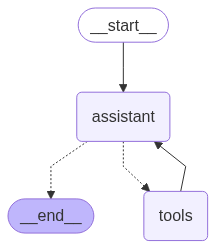

In [23]:
# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode([add, multiply, determine_outcome]))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [24]:
messages = [HumanMessage(content="My defender has a +2 defense. The attack has a +1 modifier for range and +2 modifier for moving. "
"I need to determine wether my defender passes the attack role by summing together the defense and modifers and then checking the outcome versus a dice roll.")]
messages = react_graph.invoke({"messages": messages})

In [25]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

My defender has a +2 defense. The attack has a +1 modifier for range and +2 modifier for moving. I need to determine wether my defender passes the attack role by summing together the defense and modifers and then checking the outcome versus a dice roll.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_TniFw43uLULeFf2uHxRI8Brt)
 Call ID: call_TniFw43uLULeFf2uHxRI8Brt
  Args:
    a: 1
    b: 1
  multiply (call_TifdYyMGdbOTzr7eq6o9svxi)
 Call ID: call_TifdYyMGdbOTzr7eq6o9svxi
  Args:
    a: 2
    b: 1
  multiply (call_wHcrIyp3CbHqYcBhUgumZaCb)
 Call ID: call_wHcrIyp3CbHqYcBhUgumZaCb
  Args:
    a: 2
    b: 1
================================= Tool Message =================================
Name: multiply

1
================================= Tool Message =================================
Name: multiply

2
================================= Tool Message